# AIS Vessel Trajectory Prediction - Report

In [1]:
#!pip install xgboost

In [53]:
import pandas as pd
import pandas.api.types
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data preparation

### Data collection

In [3]:
# Training data
train = pd.read_csv("data/ais_train.csv",sep="|")
df_train = train.copy()
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [4]:
# Test data
test = pd.read_csv("data/ais_test.csv",sep=",")
df_test = test.copy()
df_test.head()

,ID,vesselId,time,scaling_factor
0,0,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,0.3
1,1,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,0.3
2,2,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,0.3
3,3,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,0.3
4,4,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,0.3


In [5]:
# Additional dataframes
df_port = pd.read_csv("data/ports.csv",sep="|")
df_vessels = pd.read_csv("data/vessels.csv",sep="|")
df_schedule = pd.read_csv("data/schedules_to_may_2024.csv",sep="|")

### Data cleaning

In [6]:
# Time to datetime
df_train['time'] = pd.to_datetime(df_train['time'])
df_test['time'] = pd.to_datetime(df_test['time'])

In [7]:
# Nan values in train set
print("Train set")
print(f'Number of missing values: \n{df_train.isna().sum().sort_values(ascending=False)} \n')
print(f'Number of duplicated values: {df_train.duplicated().sum()}')

Train set
Number of missing values: 
portId       1615
time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
dtype: int64 

Number of duplicated values: 0


The training dataset includes NaN-values, but just for the portId. There are however no duplicates. The portId contains the next portId for each vessel and it is therefore constant until a port is reached. Then the portId is updated to the next destination. A method for filling this NaN-values is insert the previous portId for that ship, i.e. apply the LOCF (Last Observation Carried Forward) method. To handle possible NaN-values at the start of each portId-series, one can implement the NOCB (Next Observation Carried Backward) method, which takes the next non-null value and places it before.

In [8]:
# # Filling NaN values in PortId
# ffill -> LOCF, bfill -> NOCF
df_train['portId'] = df_train.groupby('vesselId')['portId'].ffill().bfill()
print(f'Number of missing values: \n{df_train.isna().sum().sort_values(ascending=False)} \n')


Number of missing values: 
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId       0
dtype: int64 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shippingLineId  711 non-null    object 
 1   vesselId        711 non-null    object 
 2   CEU             711 non-null    int64  
 3   DWT             703 non-null    float64
 4   GT              711 non-null    int64  
 5   NT              187 non-null    float64
 6   vesselType      699 non-null    float64
 7   breadth         703 non-null    float64
 8   depth           242 non-null    float64
 9   draft           10 non-null     float64
 10  enginePower     691 non-null    float64
 11  freshWater      221 non-null    float64
 12  fuel            221 non-null    float64
 13  homePort        573 non-null    object 
 14  length          711 non-null    float64
 15  maxHeight       35 non-null     float64
 16  maxSpeed        213 non-null    float64
 17  maxWidth        35 non-null     flo

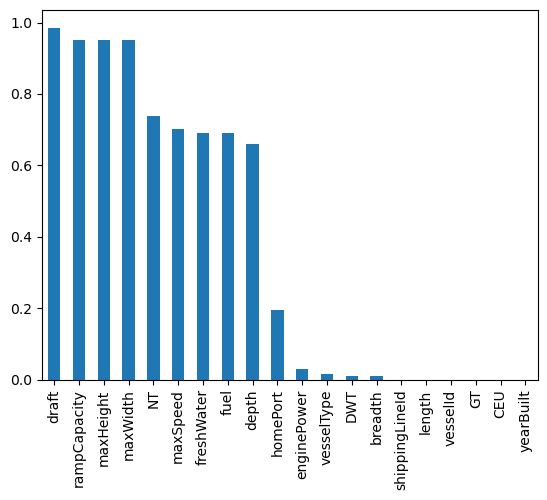

In [9]:
# Nan values in vessel set
df_vessels.info()

(df_vessels.isnull().sum().sort_values(ascending=False)/df_vessels.shape[0]).plot(kind='bar')
plt.show()

First of all, there are many null-values for some of the features. Even leading imputational methodes such as the MissForest performs releatively bad when the rate of missing values exceeds $30\%$ (Stekhoven and Bühlmann 2011). Therfore only the features 'homePort', 'enginePower', 'vesselType', 'DWT', 'breadth', 'shippingLineId', 'length', 'vesselId', 'GT', 'CEU' and 'yearBuilt' are useful features.

In [10]:
df_vessels.drop(["draft", "rampCapacity", "maxWidth", "NT", "maxSpeed", "freshWater", "fuel", "depth"], axis=1, inplace=True)
print(f'Number of missing values: \n {df_vessels.isnull().sum()}')

Number of missing values: 
 shippingLineId      0
vesselId            0
CEU                 0
DWT                 8
GT                  0
vesselType         12
breadth             8
enginePower        20
homePort          138
length              0
maxHeight         676
yearBuilt           0
dtype: int64


Earliest arrivaldate: 2013-08-11 06:00:00
Latest arrivaldate: 2054-05-25 14:00:00


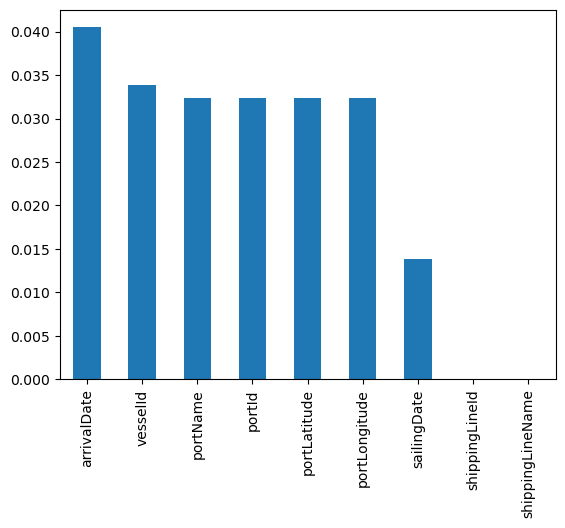

In [11]:
df_schedule['arrivalDate'] = pd.to_datetime(df_schedule['arrivalDate']).dt.tz_localize(None)
df_schedule['sailingDate']= pd.to_datetime(df_schedule['sailingDate']).dt.tz_localize(None)
print(f'Earliest arrivaldate: {df_schedule["arrivalDate"].min()}')
print(f'Latest arrivaldate: {df_schedule["arrivalDate"].max()}')
(df_schedule.isnull().sum().sort_values(ascending=False)/df_schedule.shape[0]).plot(kind='bar')
plt.show()


Here the rate of null-values are neglectable, being less than four percent, meaning that all columns can be kept for now. The categories seems useful for predicting positions of vessels in May, since the timeframe of the schedule dataset contains the destinations of ships in May. To further investigate how useful the schedule dataset is, one can look at the vesselIds in this dataset and see if they are the same ships as in the training and test set.

In [12]:
# Find common vesselIds between the test set and the schedule data
common_vessel_ids_test = df_schedule.loc[df_schedule['vesselId'].isin(df_test['vesselId']), 'vesselId'].nunique()
common_vessel_ids_train = df_schedule.loc[df_schedule['vesselId'].isin(df_train['vesselId']), 'vesselId'].nunique()

print(f'Number of common vesselIds between the test set and the schedule data: {common_vessel_ids_test}')
print(f'Number of unique vesselIds in the test set: {df_test["vesselId"].nunique()}')
print(f'Number of common vesselIds between the train set and the schedule data: {common_vessel_ids_train}')
print(f'Number of unique vesselIds in the training set: {df_train["vesselId"].nunique()}')

Number of common vesselIds between the test set and the schedule data: 67
Number of unique vesselIds in the test set: 215
Number of common vesselIds between the train set and the schedule data: 239
Number of unique vesselIds in the training set: 688


Less than half of the vessels in the test set and training set are present in the scedule dataset, which reduces the usefulness of df_schedule. It is therefore not used in the rest of this project.

## Feature Engineering

### Adding features

The portId itself is not expected to be especially important for predicting the latitude and longitude, but the location of the coming port could be of interest. Both the latitude and longitude of the ports are present in port.csv-file. In the next cell, these the relevant latitued and longitudes are merged into the training dataset. 

In [13]:
df_port.rename(columns={'longitude':'portLong', 'latitude' : 'portLat'}, inplace=True)

df_train = df_train.merge(df_port[['portId', 'portLat', 'portLong']], on='portId', how='left')
print(f'Number of missing values: \n{df_train.isna().sum().sort_values(ascending=False)} \n')


Number of missing values: 
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId       0
portLat      0
portLong     0
dtype: int64 



Some vessels do not move between timetamps. This might because they are moored due to difficult weather, they might be broken or they are at a port. To help the model understand that these ships are likely not be move, one can add a feature called e.g. moored. The way it is defined in this file is that if a ship does not move between to timestamps, it is moored. If it begins to move again, the moored parameter is set to 'False'.

In [14]:
# Adding moored as a feature

df_train['moored'] = ((df_train.groupby('vesselId')['latitude'].shift(0) == df_train.groupby('vesselId')['latitude'].shift(-1))
                   & (df_train.groupby('vesselId')['longitude'].shift(0) == df_train.groupby('vesselId')['longitude'].shift(-1))).astype(bool)


'etaRaw' is formated as an object, so in order to be able to decide if it is useful or not, it should be converted to 'datetime64[ns]'. First look at the format:

In [15]:
df_train['etaRaw'].head()
print(df_train['time'].min())

2024-01-01 00:00:25


The format is 'MM-DD HH:MM', meaning that the year is missing. Since the earliest time in the training set is $2024$, then one can expect that the 'etaRaw' should also all be in the same year, i.e $2024$.

In [16]:
df_train['etaRaw'] = ["2024-" + eta for eta in df_train['etaRaw']]
df_train['eta'] = pd.to_datetime(df_train['etaRaw'], errors = 'coerce', format='%Y-%m-%d %H:%M')
df_train.drop(['etaRaw'], axis=1, inplace=True)

print(f'Number of missing values: \n{df_train.isna().sum().sort_values(ascending=False)} \n')

Number of missing values: 
eta          3763
time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
latitude        0
longitude       0
vesselId        0
portId          0
portLat         0
portLong        0
moored          0
dtype: int64 



Since 'eta' gives an estimation to the time of arrival at at port, it should be equal (or almost equal in case of a potential delay) to the eta of the previous or next entry for the same ship. Therefore the LOCF and NOCB imputational methods describes before should be useful.

In [17]:
df_train['eta'] = df_train.groupby('vesselId')['eta'].ffill().bfill()
print(f'Number of missing values: \n{df_train.isna().sum().sort_values(ascending=False)} \n')


Number of missing values: 
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
latitude     0
longitude    0
vesselId     0
portId       0
portLat      0
portLong     0
moored       0
eta          0
dtype: int64 



### Data Distribution


Before moving on to the prediction itself, it is wise to look at how the data are distributed.

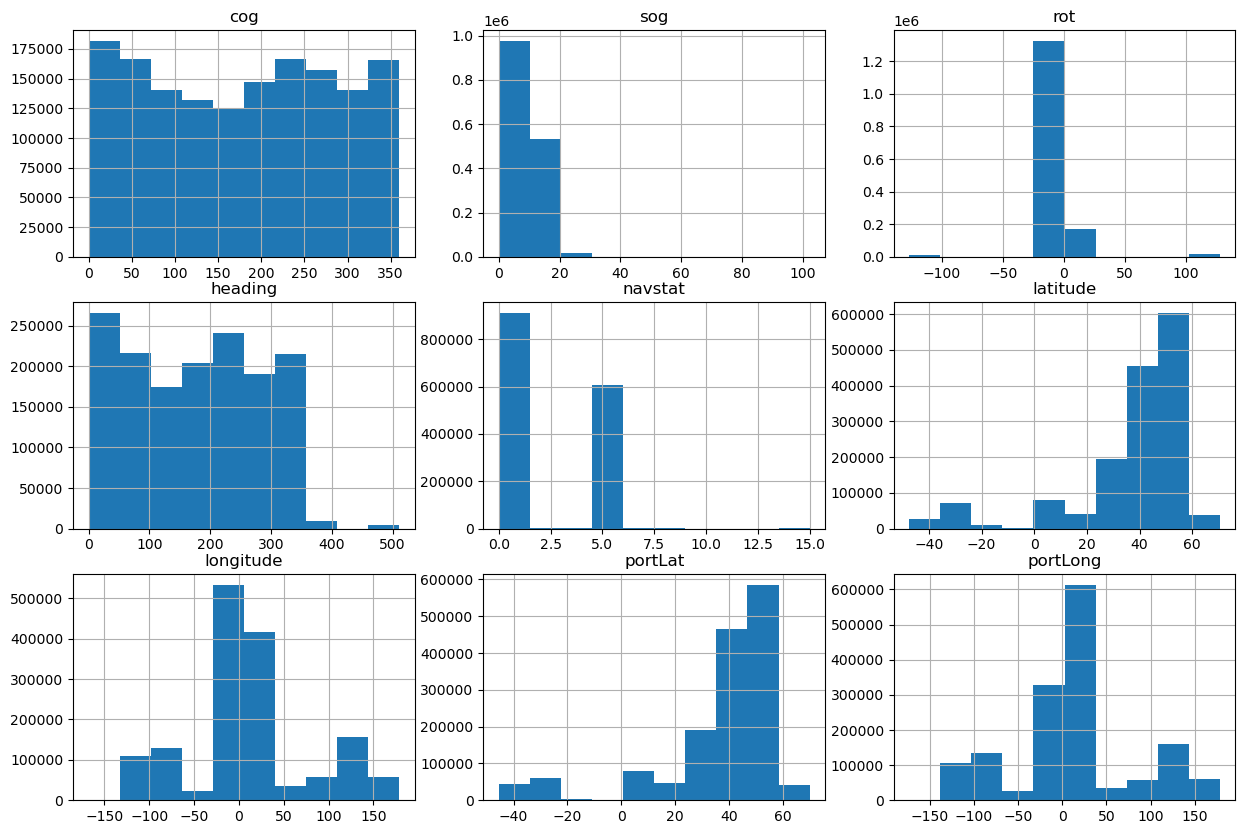

In [18]:
plt.figure(figsize = (15,10))

for i, col in enumerate(df_train.select_dtypes(include=np.number).columns):
    plt.subplot(3,3,i+1)
    df_train[col].hist()
    plt.title(col)
plt.show()

From the histograms above, one can observe that none of the numerical features are normalized. Using XGBoost which relies on decision trees, the shape of the distribution is not too important. For simplicity, the variables are not normalized or scaled in this report.

### Important features

The dataset is large, and has many different columns. Intuitively, different features impact the latitude and longitude differently. To simplify the computational power, one can remove features that do not contribute much to the labels. One way of doing this is to look at the correlation coefficient between the variables.

<Axes: >

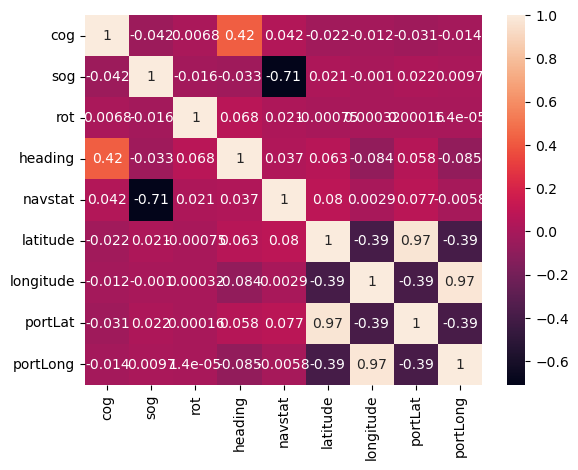

In [19]:
sns.heatmap(df_train.select_dtypes(include=np.number).corr(), annot=True)

Looking at the correlation matrix above, one can see that rot is expected to be neglectable. Alse longitude and latitude are each others most important feature by far. That implies that the positional features should be exploited the most. Merging with what is left of 'df_port' and 'df_vessels', one can see how the rest of the features are correlated wiht latitude and longitude.

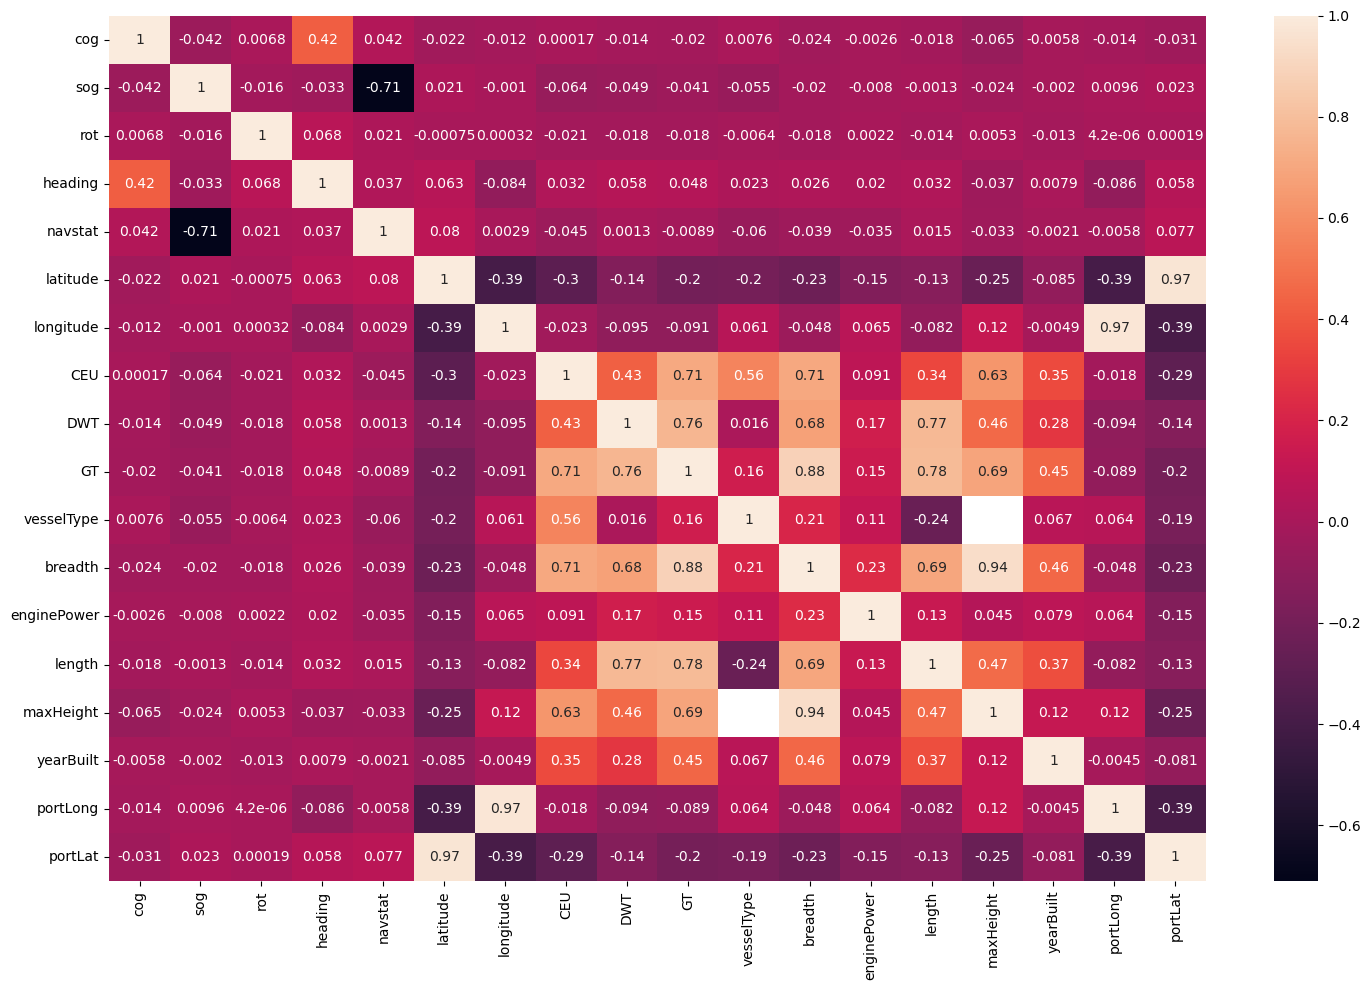

In [20]:
df_tot = pd.merge(train, df_vessels, on='vesselId', how='left')
df_tot = pd.merge(df_tot, df_port, on='portId', how='left')

plt.figure(figsize = (15,10))
sns.heatmap(df_tot.select_dtypes(include=np.number).corr(), annot=True)
plt.tight_layout()
plt.show()

The most correlated features by absoulte value with latitude are portLat, portLong and longitude. CEU, DWT, GT, vesselType, breath, lenght and and maxHeight scores more than the rest of the features, but by intuition vesselspecific details like the weight and length should not be too important for the position. These are therefore neglected. For longitude, the most correlated features are portLong, portLat, latitude. The rest can be neglected. From now on, the only variables looked at is the ones from the training dataset and the longitude and latitude of the relevant ports, from 'df_port'.

To more accurately estimate the number of features needed for the dataset, one can do a Primary Component Analysis (PCA). This data analysis method explains the percantage of the variance explained by the number of components. The PCA does however not tell us which features that should be kept, but only a linear comibnation of the features that are important.

In [21]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#variable reduction
X = scale(df_train.select_dtypes(include=np.number))
pca = PCA()
C = pca.fit(X).transform(X)

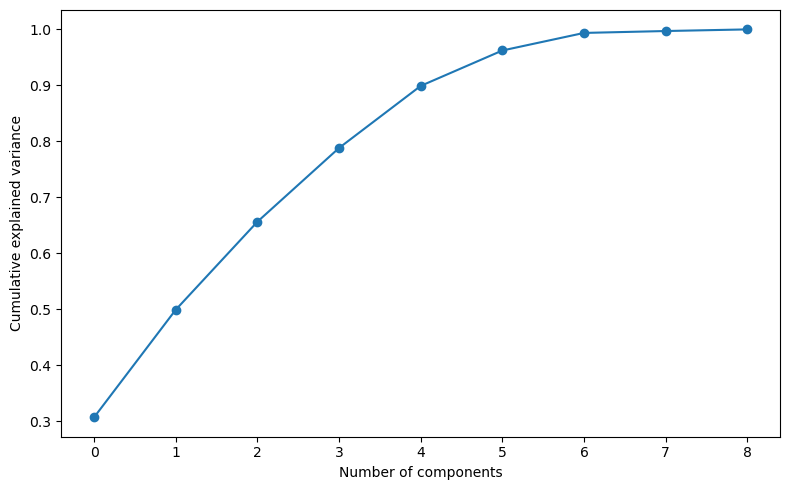

In [22]:
plt.figure(figsize=(8,5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

plt.tight_layout()
plt.show()

From the plot of the cumulative explaiend variance above, one can observe that three components are enough to explain more than $80\%$ of the variance in the train dataset, meaning that using only four components should be enough to explain most of the behviour in the training set. There is however a way to see how the different features relate to the labels of interest, and that is to look at the correlation circles.

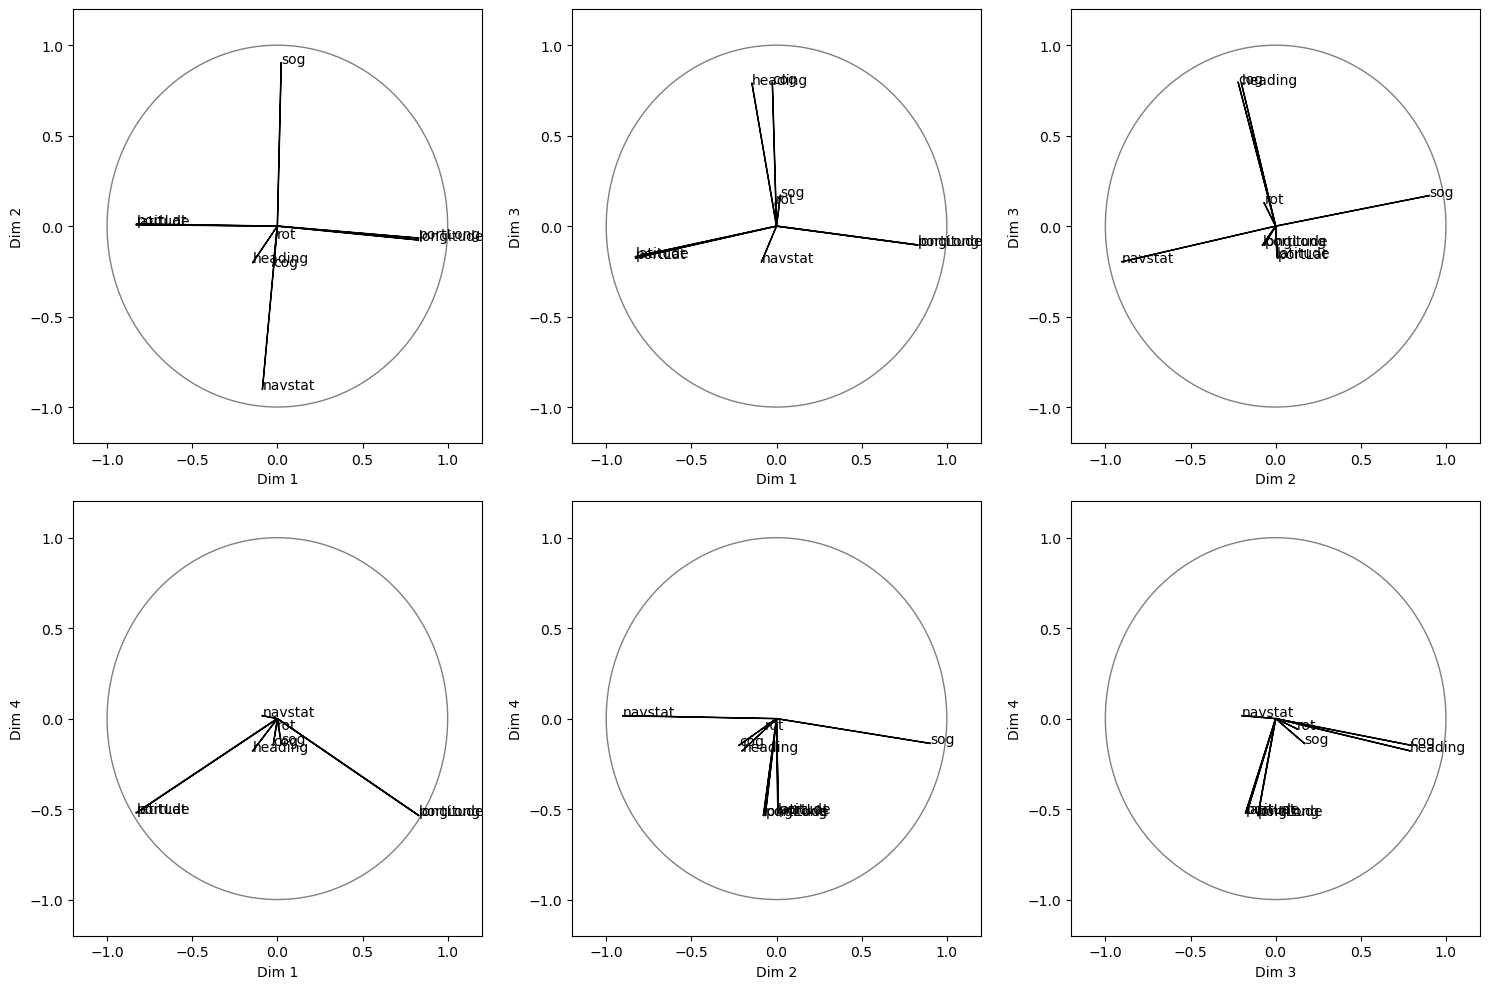

In [23]:
comp1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
comp2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
comp3=pca.components_[2]*np.sqrt(pca.explained_variance_[2])
comp4=pca.components_[3]*np.sqrt(pca.explained_variance_[3])

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2, 3, 1)
for i, j, name in zip(comp1,comp2, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(1))
    plt.ylabel("Dim "+str(2))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)

ax = fig.add_subplot(2, 3, 2)
for i, j, name in zip(comp1,comp3, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(1))
    plt.ylabel("Dim "+str(3))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)

ax = fig.add_subplot(2, 3, 3)
for i, j, name in zip(comp2,comp3, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(2))
    plt.ylabel("Dim "+str(3))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)

ax = fig.add_subplot(2, 3, 4)
for i, j, name in zip(comp1,comp4, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(1))
    plt.ylabel("Dim "+str(4))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)

ax = fig.add_subplot(2, 3, 5)
for i, j, name in zip(comp2,comp4, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(2))
    plt.ylabel("Dim "+str(4))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)

ax = fig.add_subplot(2, 3, 6)
for i, j, name in zip(comp3,comp4, df_train.select_dtypes(include=np.number).columns):
    plt.text(i, j, name)
    plt.arrow(0,0,i,j,color='black')
    plt.xlabel("Dim "+str(3))
    plt.ylabel("Dim "+str(4))
plt.axis((-1.2,1.2,-1.2,1.2))
# circle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.tight_layout()
plt.show()

From the correlation circles, one can observe that the features 'sog' and 'navstat' are almost orthogonal to 'longitude' and 'latitude' in all of the six component spaces, meaning that they do almost non-correlated for the three first principal components. They are therefore then removed reduce the computational demand.

In [24]:
# Remove 'sog' and 'navstat' features
df_train.drop(['sog', 'navstat'], axis=1, inplace=True)

### Dataframe manipulation for time series

Until now only relations between features have been investigated. That is important for the performance of the machine learning model. But how does the machine learning model understand how to predict future values? This is an important and difficult part of the data preparation. After much testing, it was found that shifting the labels in regard to the training features and concatanating the changed dataframes, gave good predictions. Furthermore, to make the model take into account the time relation between the current position and the shifted position, the time difference between these timestamps where added to a new column called 'dt'. Adding the 'dt' column also made the model more robust to incoherence in the 'time' column, as some ships do not have entires for each twenty minutes as they should. Two help the model understand the structures of the the shifted dataset, I gave it a slow start, meaning that the shifting get gradually larger per step. I choose to use the exponential function $f(n)=2^n$ which doubles the shift from iteration to iteration. As the shift gets larger and larger, there are more and more values that do not have excisting labels. Therefore only the part of the dataframes where both features and shifted labels are present, i.e all rows except for the last $n$ ones.

In [25]:
n_arr = [2**n for n in range(1, 11)]  # Array of shifting values. Following f(x)=2^n
print(n_arr)
X_list = []    # Empty list to store the shifted dataframes, here features
y_list = []    # Empty list to store the shifted dataframes, here target labels

for n in n_arr:
    df_copy = df_train.copy()    # Temporary copies to not overwrite the original data
    df_copy_grouped = df_copy.groupby('vesselId')  # Grouped per vessel
    
    # Removing potential former indexing
    df_copy = df_copy.reset_index()        

    # Features
    #    - Keep all rows except for the last n rows. Features not shifted
    df_copy_x = df_copy_grouped.apply(lambda x: x.iloc[:-n]).reset_index(drop=True)
    # Labels
    #   - Shifted by n rows and remove the last n rows
    df_copy_y = df_copy_grouped.apply(lambda x: x.shift(-n).iloc[:-n]).reset_index(drop=True)

    # Add the time difference as a new feature
    df_copy_x['dt'] = (pd.to_datetime(df_copy_y['time']) - pd.to_datetime(df_copy_x['time'])).dt.total_seconds() / 60

    # Add shifted dataframes
    X_list.append(df_copy_x)
    y_list.append(df_copy_y)

# Concatenate the dataframes
X_tr = pd.concat(X_list, ignore_index=True)
y_tr = pd.concat(y_list, ignore_index=True)



[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


C:\Users\jonas\AppData\Local\Temp\ipykernel_16564\1995465038.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy_x = df_copy_grouped.apply(lambda x: x.iloc[:-n]).reset_index(drop=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_16564\1995465038.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy_y = df_copy_grouped.apply(lambda x: x.shift(-n).iloc[:-n]).reset_index(drop=True)
C:\Users\jon

In [26]:
# Shape of the manipulated dataframes
print(f"Shape of X_tr: {X_tr.shape}")
print(f"Shape of y_tr: {y_tr.shape}")

X_tr.head()
        

Shape of X_tr: (13862539, 13)
Shape of y_tr: (13862539, 12)


,time,cog,rot,heading,latitude,longitude,vesselId,portId,portLat,portLong,moored,eta,dt
0,2024-01-12 14:07:47,308.1,-6,316,7.50361,77.58340,61e9f38eb937134a3c4bfd8b,61d376b393c6feb83e5eb50c,13.263333,80.341111,False,2024-01-08 06:00:00,49.6
1,2024-01-12 14:31:00,307.6,5,313,7.57302,77.49505,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00,47.8
2,2024-01-12 14:57:23,306.8,5,312,7.65043,77.39404,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00,42.4
3,2024-01-12 15:18:48,307.9,6,313,7.71275,77.31394,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00,36.0
4,2024-01-12 15:39:47,307.0,7,313,7.77191,77.23585,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00,35.2


In [27]:
y_tr.head()

,time,cog,rot,heading,latitude,longitude,vesselId,portId,portLat,portLong,moored,eta
0,2024-01-12 14:57:23,306.8,5.0,312.0,7.65043,77.39404,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00
1,2024-01-12 15:18:48,307.9,6.0,313.0,7.71275,77.31394,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00
2,2024-01-12 15:39:47,307.0,7.0,313.0,7.77191,77.23585,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00
3,2024-01-12 15:54:48,307.6,5.0,313.0,7.81285,77.18147,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00
4,2024-01-12 16:14:59,309.5,-6.0,313.0,7.86929,77.11032,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,18.941944,72.885278,False,2024-01-14 23:30:00


In [28]:
# Number of NaN values
print(f'Number of missing values in X_tr: \n{X_tr.isna().sum().sort_values(ascending=False)} \n')
print(f'Number of missing values in y_tr: \n{y_tr.isna().sum().sort_values(ascending=False)} \n')

Number of missing values in X_tr: 
time         0
cog          0
rot          0
heading      0
latitude     0
longitude    0
vesselId     0
portId       0
portLat      0
portLong     0
moored       0
eta          0
dt           0
dtype: int64 

Number of missing values in y_tr: 
time         0
cog          0
rot          0
heading      0
latitude     0
longitude    0
vesselId     0
portId       0
portLat      0
portLong     0
moored       0
eta          0
dtype: int64 



The lenghts of the features and labels are equal and they do not contain NaN-values, which indicates that the manipulation worked as intented. From the the first five lines of the dataframes one also observes that the latitude and longitude of a time in X_tr is the same as the next time in y_tr.

For clarifying that the latitude and longitude in X_tr are the last observed values before each label, they are renamed.

In [29]:
# Renaming longitude and latitude features
X_tr.rename(columns={'longitude': 'last_longitude', 'latitude':'last_latitude'}, inplace=True)

### Splitting into training and validation sets

In [30]:
split_index = 10  # The number of last rows per ship used in validation

# Validation set - features
X_val = X_tr.groupby('vesselId').tail(split_index)
# Training set - features
X_tr = X_tr.groupby('vesselId').apply(lambda x: x.iloc[:-split_index]).reset_index(drop=True)

# Validation set - labels
y_val = y_tr.groupby('vesselId').tail(split_index)[['latitude', 'longitude']]
# Training set - labels
y_tr = y_tr.groupby('vesselId').apply(lambda x: x.iloc[:-split_index]).reset_index(drop=True)[['latitude', 'longitude']]

print(f"Shape of X_tr: {X_tr.shape}")
print(f"Shape of y_tr: {y_tr.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

C:\Users\jonas\AppData\Local\Temp\ipykernel_16564\1952235743.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_tr = X_tr.groupby('vesselId').apply(lambda x: x.iloc[:-split_index]).reset_index(drop=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_16564\1952235743.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_tr = y_tr.groupby('vesselId').apply(lambda x: x.iloc[:-split_index]).reset_index(drop=T

Shape of X_tr: (13855669, 13)
Shape of y_tr: (13855669, 2)
Shape of X_val: (6870, 13)
Shape of y_val: (6870, 2)


Features and labels have the same size both for the traning sets and the validation sets.

### Creating test dataframe

To help the machine learning model start at the same state as the last state of the training data. Therefore The last value per feature per ship is added to the test set. Then it is merged with the test data, to add the correct time and make the test dataframe as long as the original test data.

In [31]:
# Fetching last value per feature per vessel in the training set
X_te = df_train.groupby('vesselId').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
# Merge with the test set
X_te = df_test.merge(X_te, on='vesselId', how='left', suffixes=('_new',''))
# Add the time difference as a new feature
X_te['dt'] = (X_te['time_new'] - X_te['time']).dt.total_seconds()/60
# Rename latitude and longitude features
X_te.rename(columns={'longitude': 'last_longitude', 'latitude':'last_latitude'}, inplace=True)


C:\Users\jonas\AppData\Local\Temp\ipykernel_16564\1621491767.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_te = df_train.groupby('vesselId').apply(lambda x: x.iloc[-1]).reset_index(drop=True)


## Prediction

### XGBoost

In this project, the xgboost was used as the workhorse for predicting, as it is fast, reliable and effective at tuning. The XGBoost only uses numerical features, but the dataset still contains some non-numeric, like 'time', 'eta', 'vesselId' and 'portId'. All of these are possible to convert to numerical values and used. Does it make sense to insert all of them as numerical values? One can argue that time is essential to predict the future positions at exact timestamps, but the feature 'dt' was introduced and since it is calculated from 'time', they share most of the relevant information. The feature 'time' will therefore be dropped before running the model. 

'portId' is another non-numeric feature. It is belived that 'portLat' and 'portLong' include the most relevant information from 'portId' regarding the latitude and longitude of the ships. Since they are already in the training set, 'portId' removed before training the model.

In [ ]:
# Caterogical to numerical
X_tr['eta'] = X_tr['eta'].astype('int64') / 1e9  # ETA in seconds
X_tr['vesselId'] = X_tr['vesselId'].astype('category').cat.codes # VesselId as numerical

X_val['eta'] = X_val['eta'].astype('int64') / 1e9  # ETA in seconds
X_val['vesselId'] = X_val['vesselId'].astype('category').cat.codes # VesselId as numerical

# Removing features
X_tr.drop(['time', 'portId', 'eta'], axis=1, inplace=True)
X_val.drop(['time', 'portId', 'eta'], axis=1, inplace=True)


X_tr.drop(['vesselId'], axis=1, inplace=True,)
X_val.drop(['vesselId'], axis=1, inplace=True,)

In [37]:
# Fitting the model
# Create instance
clf = xgb.XGBRegressor(verbosity=2) # Verbosity to see the progress
# Fit the model
clf.fit(X_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

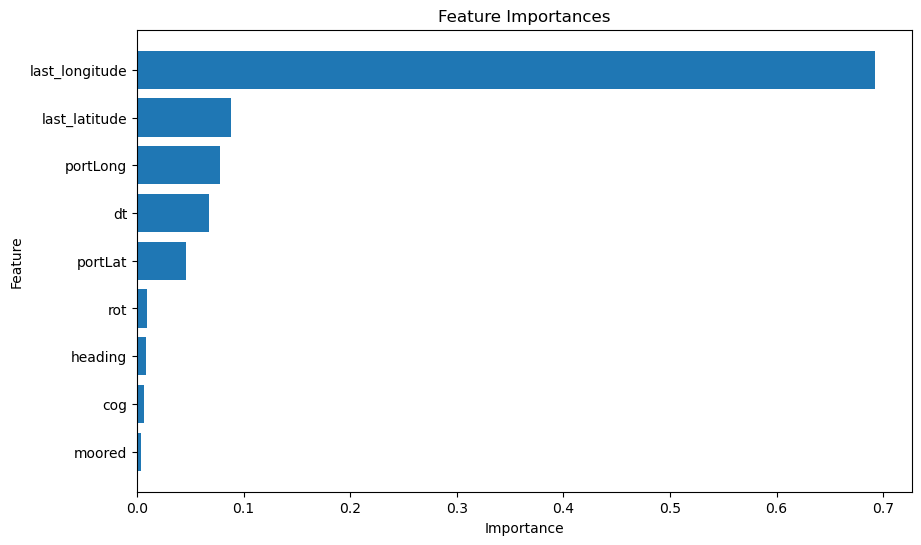

          feature  importance
4  last_longitude    0.692261
3   last_latitude    0.087793
6        portLong    0.077826
8              dt    0.067750
5         portLat    0.046042
1             rot    0.009134
2         heading    0.008686
0             cog    0.006930
7          moored    0.003577


In [38]:
# 3) Access the feature importances
feature_importances = clf.feature_importances_

# 4) Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 5) Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Print the feature importances DataFrame
print(feature_importances_df)

The 'moored' feature is not important at all for this XGBoost instance, and is removed to reduce computational demands.

In [39]:
X_tr.drop(['moored'], axis=1, inplace=True)
X_val.drop(['moored'], axis=1, inplace=True)

Through many rounds of hyperparameter tuning the following values for estimators were found. I started by using values far appart and then gradually trimmed the interval. For the parameter 'n_estimator' I tested values between $100$ and $600$, for 'max_depth' $1-15$, 'learning_rate': $0.01-0.2$ and 'min_child_weight': $1-10$. The method is as seen in the code cell above, where I chose a comibination of values and did a gridserach using cross-validation with five folds, as the datasets are quite large. 

In [40]:
# Define GridSearch parameters
param_grid = {
    'n_estimators': [500],
    'max_depth': [6],
    'learning_rate' : [0.075],
    'min_child_weight': [1],
}

In [41]:
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3) 
grid_search.fit(X_tr, y_tr)
print(f"Best parameters: {grid_search.best_params_} ")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.075, max_depth=6, min_child_weight=1, n_estimators=500;, score=0.806 total time= 3.6min
[CV 2/5] END learning_rate=0.075, max_depth=6, min_child_weight=1, n_estimators=500;, score=0.821 total time= 3.6min
[CV 3/5] END learning_rate=0.075, max_depth=6, min_child_weight=1, n_estimators=500;, score=0.820 total time= 3.6min
[CV 4/5] END learning_rate=0.075, max_depth=6, min_child_weight=1, n_estimators=500;, score=0.859 total time= 3.5min
[CV 5/5] END learning_rate=0.075, max_depth=6, min_child_weight=1, n_estimators=500;, score=0.833 total time= 3.4min
Best parameters: {'learning_rate': 0.075, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500} 


In [42]:
# Predict on the validation set
y_pred_tuned = grid_search.predict(X_val)

In [43]:
# Evaluate the tuned model
mse_tuned = mean_squared_error(y_val, y_pred_tuned)
mae_tuned = mean_absolute_error(y_val, y_pred_tuned)
r2_tuned = r2_score(y_val, y_pred_tuned)

print("Tuned Model Performance:")
print(f"Mean Squared Error (MSE): {mse_tuned}")
print(f"Mean Absolute Error (MAE): {mae_tuned}")
print(f"R^2 Score: {r2_tuned}")

Tuned Model Performance:
Mean Squared Error (MSE): 3139.9702565286852
Mean Absolute Error (MAE): 36.86660850456875
R^2 Score: 0.2175398343250508


The scores themselves are quite high, but that is due to the fact that there are many vessels and that jsut the ten last values of the training data are used for validation. 

In [44]:
# Create instance with tuned hyperparameters
clf_optimal = xgb.XGBRegressor(**grid_search.best_params_)
# Fit the model
clf_optimal.fit(X_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.075, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
# Predict on the test set
y_pred_optimal_result = clf_optimal.predict(X_te.drop(['time', 'time_new', 'scaling_factor', 'ID', 'portId', 'moored', 'eta', 'vesselId'], axis=1))

In [51]:
# Exporting the results
results_df = pd.DataFrame(y_pred_optimal_result, columns=['latitude', 'longitude'])
results_df['ID'] = X_te['ID']
results_df = results_df[['ID', 'latitude', 'longitude']]
results_df.rename(columns={'latitude': 'latitude_predicted', 'longitude': 'longitude_predicted'}, inplace=True)
results_df.to_csv("results.csv", index=False)

In [ ]:
visualize_df = pd.DataFrame(y_pred_optimal_result, columns=['latitude', 'longitude'])
visualize_df['ID'] = X_te['ID']
visualize_df['vesselId'] = X_te['vesselId']
visualize_df['time'] = X_te['time_new']
visualize_df.to_csv("visualize.csv", index=False)

### Linear Regression

On short distances the ships are expected to move in straight lines. This is due to the fact that the ships do not move to fast and that they should travel the shortest route to save fuel and costs. It is therefore intresting to see if a linear model performs well at predicting the vessels location. The penalization is introduced through LASSO penalization for better interpretability.

In [54]:
# Scaling
X_tr_scaled = StandardScaler().fit_transform(X_tr)
X_val_scaled = StandardScaler().fit_transform(X_val)

regLasso = linear_model.Lasso()
regLasso.fit(X_tr_scaled,y_tr)

Lasso()

In [61]:
# Feauture importance

# Latitude
feature_importance_lat = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': regLasso.coef_[0,:]
})

feature_importance_lat = feature_importance_lat.sort_values(by='importance', ascending=False)

print(f'Feautere importance for latitude: {feature_importance_lat}')

# Longitude
feature_importance_long = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': regLasso.coef_[1,:]
})

feature_importance_long = feature_importance_long.sort_values(by='importance', ascending=False)

print(f'Feautere importance for longitude: {feature_importance_long}')

Feautere importance for latitude:           feature  importance
3   last_latitude   12.986490
5         portLat    5.284697
0             cog   -0.000000
1             rot    0.000000
2         heading   -0.000000
4  last_longitude   -0.000000
7              dt   -0.000000
6        portLong   -0.002261
Feautere importance for longitude:           feature  importance
4  last_longitude   35.449149
6        portLong   17.431283
0             cog   -0.000000
1             rot    0.000000
2         heading   -0.000000
7              dt    0.000000
5         portLat   -0.841810
3   last_latitude   -2.301072


Most of the features are put to zero by the LASSO penalization, except for the latitude and longitude features. Also the latitude does not contribute at all to the longitude prediction and vice versa. This is inline with the variables with the largest correlation coefficients eralier in the report. It also makes sense that the latest latitde/longitude should be important for the future position, as is is close and that it the movement should go from the starting point. The positional feature of the ports are also a good indication for where the vessel is headed. 

In [ ]:
param=[{"alpha":[0.05,0.1,0.5]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5, verbose=3)

regLasso_opt = regLasso.fit(X_tr_scaled, y_tr)
optimal_parameters = regLasso_opt.best_params_["alpha"]
print(f"Best R2-score = {regLasso_opt.best_score_}, Best parameters = {regLasso_opt.best_score_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ........................alpha=0.05;, score=0.649 total time=  38.0s
[CV 2/5] END ........................alpha=0.05;, score=0.652 total time=  38.2s
[CV 3/5] END ........................alpha=0.05;, score=0.649 total time=  41.0s
[CV 4/5] END ........................alpha=0.05;, score=0.761 total time=  39.7s
[CV 5/5] END ........................alpha=0.05;, score=0.796 total time=  38.1s
[CV 1/5] END .........................alpha=0.1;, score=0.649 total time=  34.1s
[CV 2/5] END .........................alpha=0.1;, score=0.652 total time=  38.3s
[CV 3/5] END .........................alpha=0.1;, score=0.649 total time=  37.4s
[CV 4/5] END .........................alpha=0.1;, score=0.761 total time=  43.7s
[CV 5/5] END .........................alpha=0.1;, score=0.796 total time=  38.9s
[CV 1/5] END .........................alpha=0.5;, score=0.650 total time=  31.8s
[CV 2/5] END .........................alpha=0.5;,

From the this gridesearch one can see that all of the paramteres tested give approximately the same scores. This indicated that the difference between the importance of the varaibles are large, so large that either with small penalization, the least important are removed. 

In [76]:
regLasso = linear_model.Lasso(alpha=optimal_parameters)
y_pred = regLasso.fit(X_tr_scaled, y_tr).predict(X_te.drop(['time_new', 'time', 'ID', 'scaling_factor', 'portId', 'moored', 'eta', 'vesselId'], axis=1))

c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [77]:
results_df_lin = pd.DataFrame(y_pred, columns=['latitude', 'longitude'])
results_df_lin['ID'] = X_te['ID']
results_df_lin.rename(columns={'latitude': 'latitude_predicted', 'longitude': 'longitude_predicted'}, inplace=True)
results_df_lin.to_csv("results_linear.csv", index=False)

# References

1. Stekhoven, D.J and Bühlmann, P. (2011) <em>MissForest - nonparametric missing value imputation for mixed-type data</em>. URL: https://arxiv.org/pdf/1105.0828
2. Sarkar, D., Bali,R. and Sharma, T. (2018) <em>Practical Machine Learning with Python</em>. Apress: California.